# Moov AI - Data science test 

**Mise en situation**

Certains gestionnaires de magasins tentent de comprendre **comment augmenter les ventes de
leurs magasins.** Ils ont à leur disposition des données historiques de ventes de différents
magasins.

**Objectif**

Développe en Python une approche ML (supervisée et/ou non supervisée) pour aider les
gestionnaires de magasins à prévoir les ventes futures.



In [1]:
# Import des données et des librairies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from IPython.display import display

# Import xgboost and sklearn
from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import train_test_split

In [37]:
# Import csv
df = pd.read_csv(r'/Users/philippebeliveau/Desktop/Notebook/Moov AI/stores_sales_forecasting.csv', encoding='ISO-8859-1')

# Transform 'Order Date' and 'Ship Date' to datetime
df['Order Date'] = pd.to_datetime(df['Order Date'])
df['Ship Date'] = pd.to_datetime(df['Ship Date']) 

# Transform the postal code in a categorical variable
df['Postal Code'] = df['Postal Code'].astype('str')
df['Row ID'] = df['Row ID'].astype('str')

print(f"Shape of the dataset: {df.shape}")
display(df.head(15).style.set_sticky().set_properties(**{'overflow-x': 'auto'}))

Shape of the dataset: (2121, 21)


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08 00:00:00,2016-11-11 00:00:00,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.960000,2,0.000000,41.913600
1,2,CA-2016-152156,2016-11-08 00:00:00,2016-11-11 00:00:00,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs, Rounded Back",731.940000,3,0.000000,219.582000
2,4,US-2015-108966,2015-10-11 00:00:00,2015-10-18 00:00:00,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.577500,5,0.450000,-383.031000
3,6,CA-2014-115812,2014-06-09 00:00:00,2014-06-14 00:00:00,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,California,90032,West,FUR-FU-10001487,Furniture,Furnishings,"Eldon Expressions Wood and Plastic Desk Accessories, Cherry Wood",48.860000,7,0.000000,14.169400
4,11,CA-2014-115812,2014-06-09 00:00:00,2014-06-14 00:00:00,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,California,90032,West,FUR-TA-10001539,Furniture,Tables,Chromcraft Rectangular Conference Tables,1706.184000,9,0.200000,85.309200
5,24,US-2017-156909,2017-07-16 00:00:00,2017-07-18 00:00:00,Second Class,SF-20065,Sandra Flanagan,Consumer,United States,Philadelphia,Pennsylvania,19140,East,FUR-CH-10002774,Furniture,Chairs,"Global Deluxe Stacking Chair, Gray",71.372000,2,0.300000,-1.019600
6,25,CA-2015-106320,2015-09-25 00:00:00,2015-09-30 00:00:00,Standard Class,EB-13870,Emily Burns,Consumer,United States,Orem,Utah,84057,West,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,1044.630000,3,0.000000,240.264900
7,28,US-2015-150630,2015-09-17 00:00:00,2015-09-21 00:00:00,Standard Class,TB-21520,Tracy Blumstein,Consumer,United States,Philadelphia,Pennsylvania,19140,East,FUR-BO-10004834,Furniture,Bookcases,"Riverside Palais Royal Lawyers Bookcase, Royale Cherry Finish",3083.430000,7,0.500000,-1665.052200
8,30,US-2015-150630,2015-09-17 00:00:00,2015-09-21 00:00:00,Standard Class,TB-21520,Tracy Blumstein,Consumer,United States,Philadelphia,Pennsylvania,19140,East,FUR-FU-10004848,Furniture,Furnishings,"Howard Miller 13-3/4"" Diameter Brushed Chrome Round Wall Clock",124.200000,3,0.200000,15.525000
9,37,CA-2016-117590,2016-12-08 00:00:00,2016-12-10 00:00:00,First Class,GH-14485,Gene Hale,Corporate,United States,Richardson,Texas,75080,Central,FUR-FU-10003664,Furniture,Furnishings,"Electrix Architect's Clamp-On Swing Arm Lamp, Black",190.920000,5,0.600000,-147.963000


# Question #1 : Préparation des données

Comme c’est souvent le cas dans les projets, le jeu de données peut nécessiter quelques
manipulations pour être utilisable par une approche ML.
- Si tu rencontres des problèmes de qualité des données durant ta manipulation des
données de ventes, comment les as-tu résolus?
- Limite-toi aux trois enjeux les plus pertinents selon toi (appuie-toi avec un visuel).
- Est-ce que les insights trouvés peuvent être transformés en features qui faciliteront
l'apprentissage du modèle M

- 'Row ID', 'Order ID', - Order identification (Combine, they form the Unique ID)
- 'Order Date', 'Ship Date', 'Ship Mode': - Speed of shippind
- 'Customer ID', 'Customer Name': Information about the consumer 
- 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region': - Geography 
- 'Product ID', 'Category', 'Sub-Category', 'Product Name', 
- 'Sales', 'Quantity', 'Discount', 'Profit'

**Business Q part 1** 
1. How to aggregate the data? 
    - 
**Business Q part 2** 
- Which product sales best? 
- Many category: ship mode, segment, city, category of products, sub category 
- Useles: - Product name won't bring anything, too granular probably. I could look if there is some product name that are very popular and recommend them to the client in order to improve his sales, but regarding modeling, probably not.
- Geography: 
    - How many store are we dealing with? 
    - How much spread are the store? Do the habit of consumption of the store/region are signifanctly different from each other? 
- The effect of the shipping on sales? 
    - Does the delay in shipping cost lower sales? 
- Consumer: Does one or few consumer take most of the sales? 
- His sales a direct function of profit? 


**Data science Q**
- Is there seasonality? 
- How to make the series? How granular we want them to be? 
- Lots of categorical variables, how many category per variables? If I want to use them, I'll probably require tree base model that can handle such data.
- Geography variale: Redundancy in postal code and city? How granular 
- Reflect on how can you assess the relationship with discount, the time and the sales/profit
- Does higher discount lead to more sales, and more profit down the line?
 
**Answer** 
1. Data quality problem
    - Need to assess outliers 
    - No duplicate rows
    - Equal timestamp between observations? 
    - Too many category per variables? 
    - How to aggregate the data? 
    - The aggregation could lead to missing value. 
    
2. Most important aspect -> ?? what makes the sales/profit fluctuates the most? 
    - The effect of Discount on Profit
    - The effect of geographical location
    - What type of product sells most? 
    - The effect of the shipping on sales? 
        - Does the delay in shipping cost lower sales?  
3. Insight found to create features?
    - Delay in shipping can affect the sales. Either make bucket of the time delays. 
    - Discount can affect or boost profit, thus we could use a lag value of the discount to forecast the profit. 
    - Profit margin -> What do you want to increase is the profit? The sales? Or the margin? -> This variable would be correlated with discount. 
    - holiday features
    - Aggregation a la semaine ou au mois pourrait aider le modele 
    - Promotional Indicators:
        - If outliers are due to promotions, create a flag (is_promotion) to indicate these events.

### Potential issue

In [24]:
# Duplicates 
df[df['Order ID'] == 'CA-2016-152156'] # Here the unique id is the 'Row ID' with the 'Order ID'

# There is no duplicates
df[df.duplicated(subset=df.columns, keep=False)]


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit


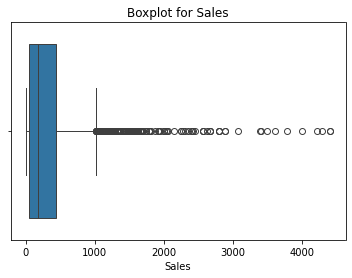

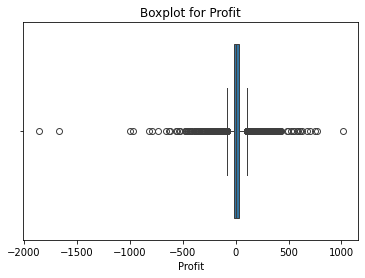

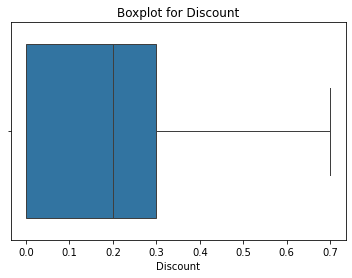

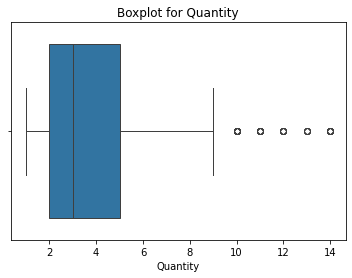

In [17]:
# Outliers 
numerical_cols = ['Sales', 'Profit', 'Discount', 'Quantity']
for col in numerical_cols:
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot for {col}")
    plt.show()


How to aggregate and at what level to study the series?

In [50]:
# At what level of granularity should I put my data? Probably not necessary at the level of the postal code 
# What level of aggreagation will make the insight relevant? 

data = df
# Convert 'Order Date' to datetime
data['Order Date'] = pd.to_datetime(data['Order Date'])

# Create a 'Store' proxy by combining City and State
data['Store'] = data['State'] # + ', ' + data['City']  # + data['Postal Code']

# Aggregate sales by Store and Date
time_series = data.groupby(['Order Date', 'Store']).agg({
    'Sales': 'sum',
    'Quantity': 'sum',
    'Profit': 'sum'
}).reset_index()

# Optionally, set 'Order Date' as the index for time series analysis
time_series = time_series.set_index('Order Date')

# Count the unique number of stores
n_stores = time_series['Store'].nunique()
print(n_stores)

time_series


48


,Store,Sales,Quantity,Profit
Order Date,,,,
2014-01-06,Kentucky,2573.820,9,746.4078
2014-01-07,Texas,76.728,3,-53.7096
2014-01-10,Virginia,51.940,1,21.2954
2014-01-11,Delaware,9.940,2,3.0814
2014-01-13,California,333.999,3,3.9294
...,...,...,...,...
2017-12-28,Washington,7.400,2,3.0340
2017-12-29,California,494.688,12,-6.8620
2017-12-29,Kentucky,1767.570,12,478.9476


# Question #2 : Insights et interprétation
Identifie des insights qui, selon toi, peuvent contribuer à comprendre les variations des ventes.
- En tenant compte des parties prenantes visées par ta solution, comment interprètes-tu les résultats produits par ta solution ML? Comment cette solution ajoute-t-elle de la valeur pour ces parties prenantes?
- Selon toi, comment envisage-tu que les parties prenantes vont utiliser ta solution pour
tenter de comprendre comment augmenter les ventes?

Methods: 
- Use of unsupervised method to find insight and add value to the clients 
- They will understand what kind of features causes what
    - Need coefficient? 
    - How to interpret? 

### Category and Sub-Category Analysis ###


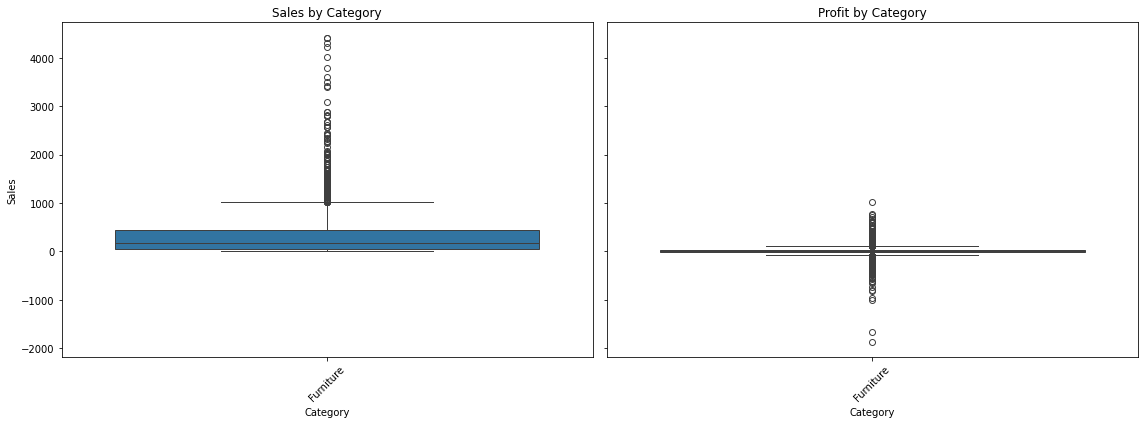

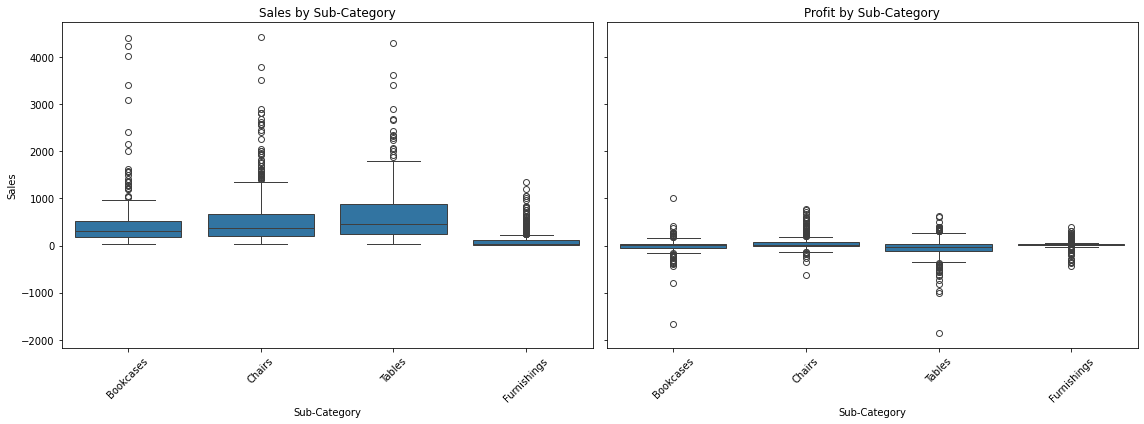

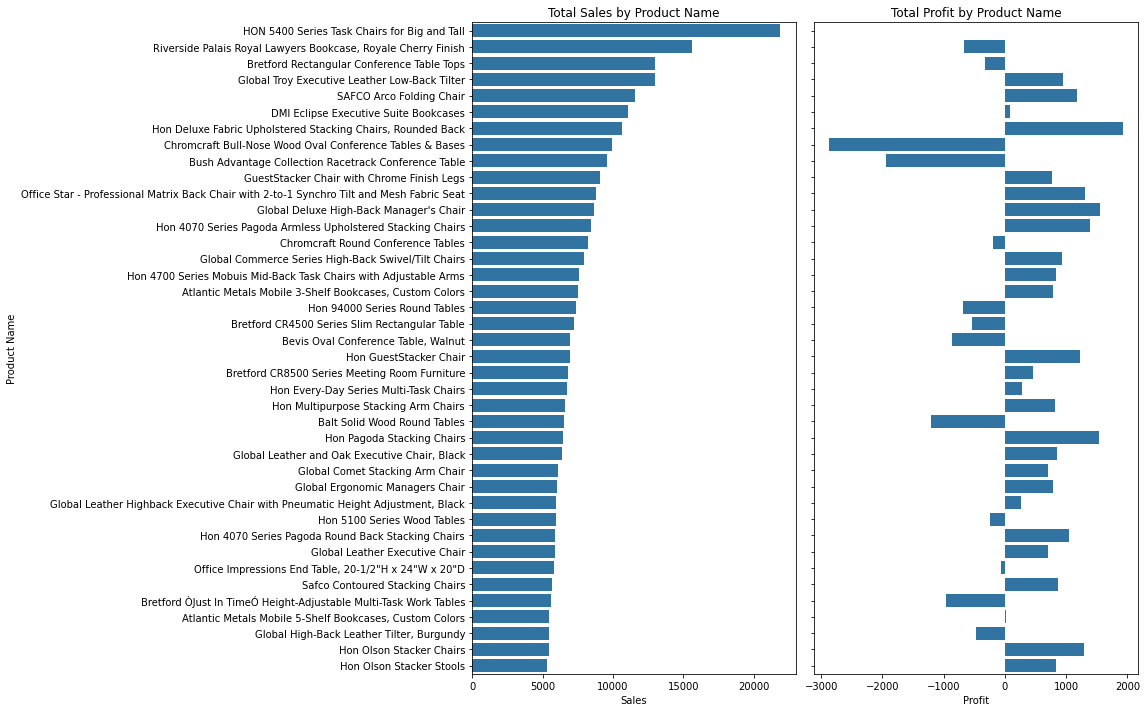

### Segment and Customer Name Analysis ###


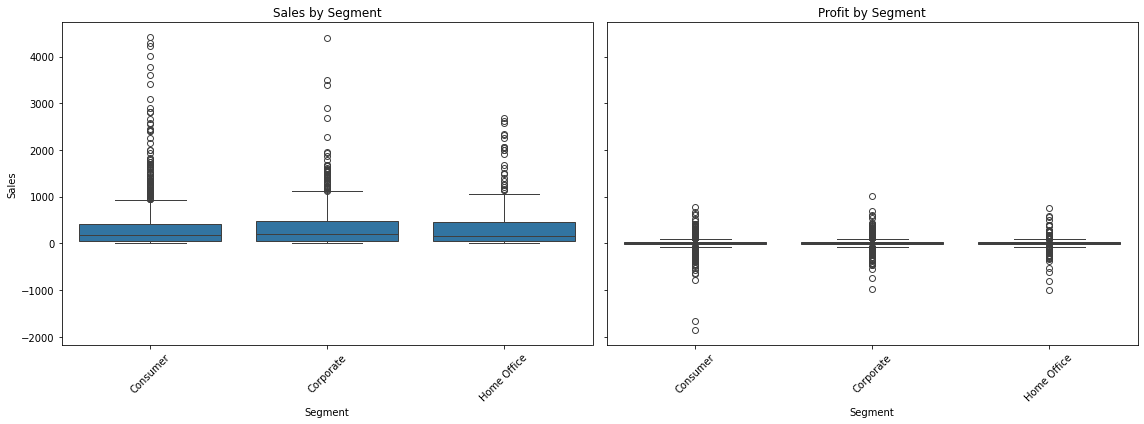

/var/folders/dj/q5s8lngd1msdbb76w1tn9x1r0000gn/T/ipykernel_91491/3124283316.py:42: UserWarning: Glyph 138 (\x8a) missing from current font.
  plt.tight_layout()
/Users/philippebeliveau/miniforge3/envs/arm64_Miniforge/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 138 (\x8a) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


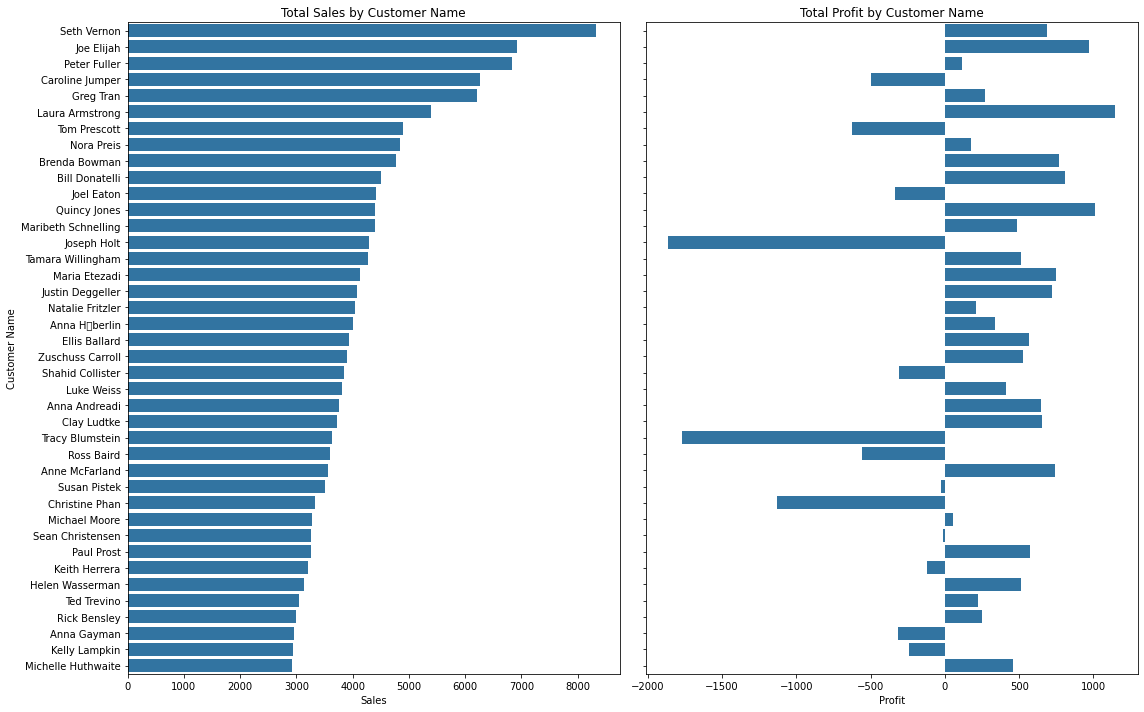

### Ship Mode Analysis ###


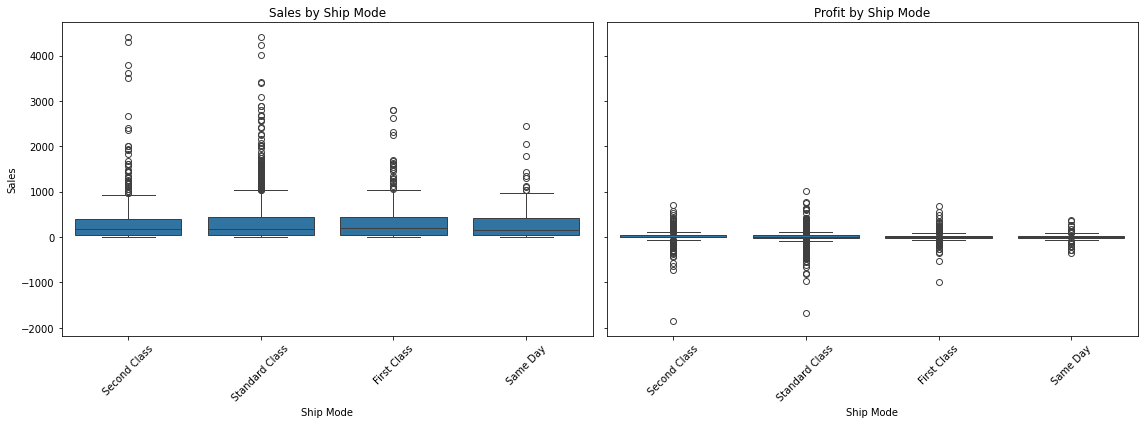

### Geography Analysis ###


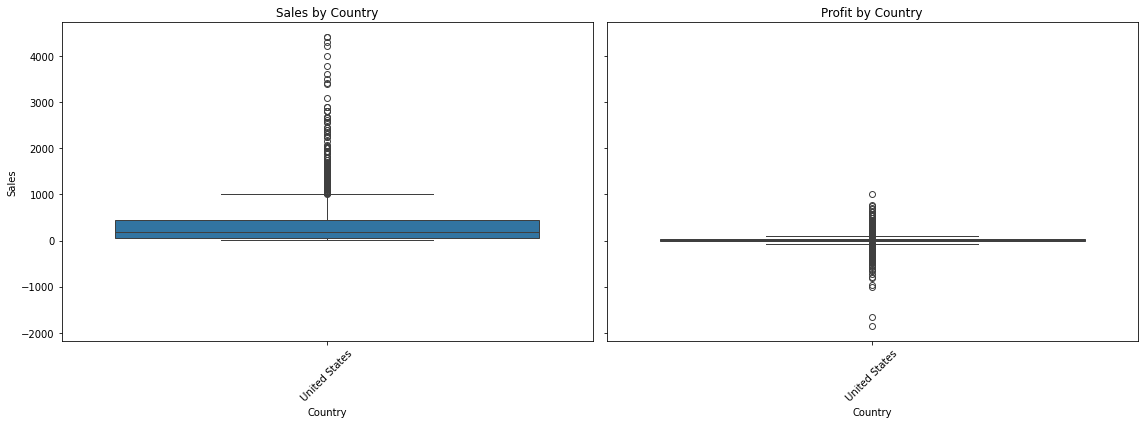

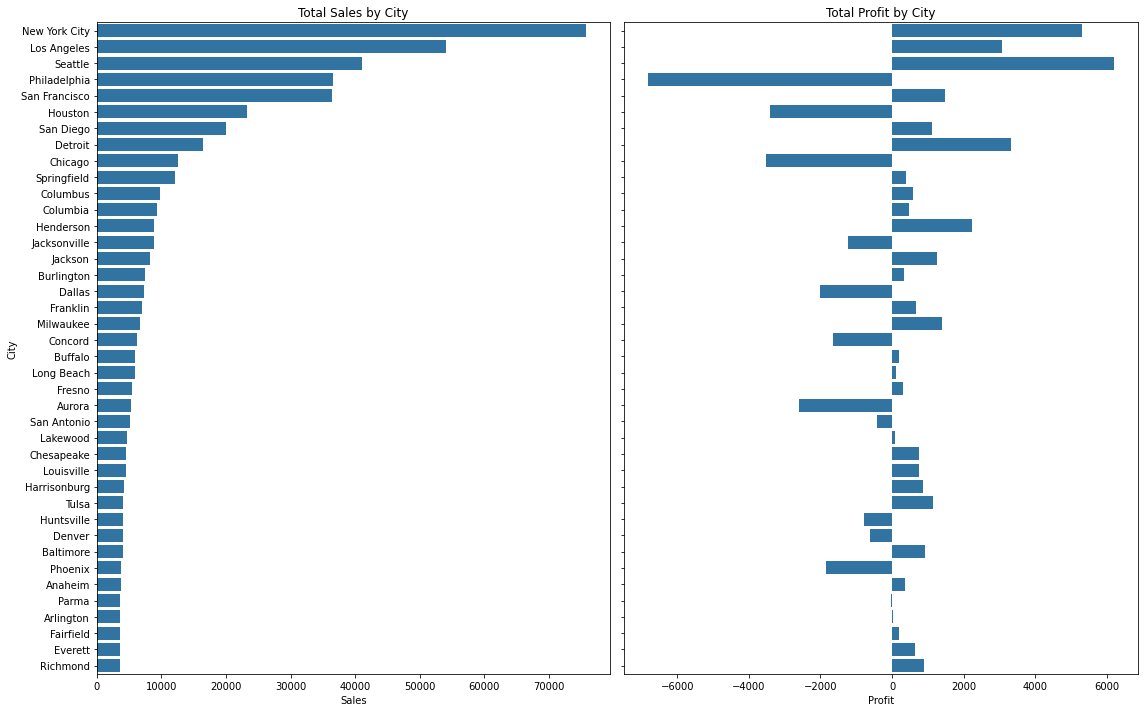

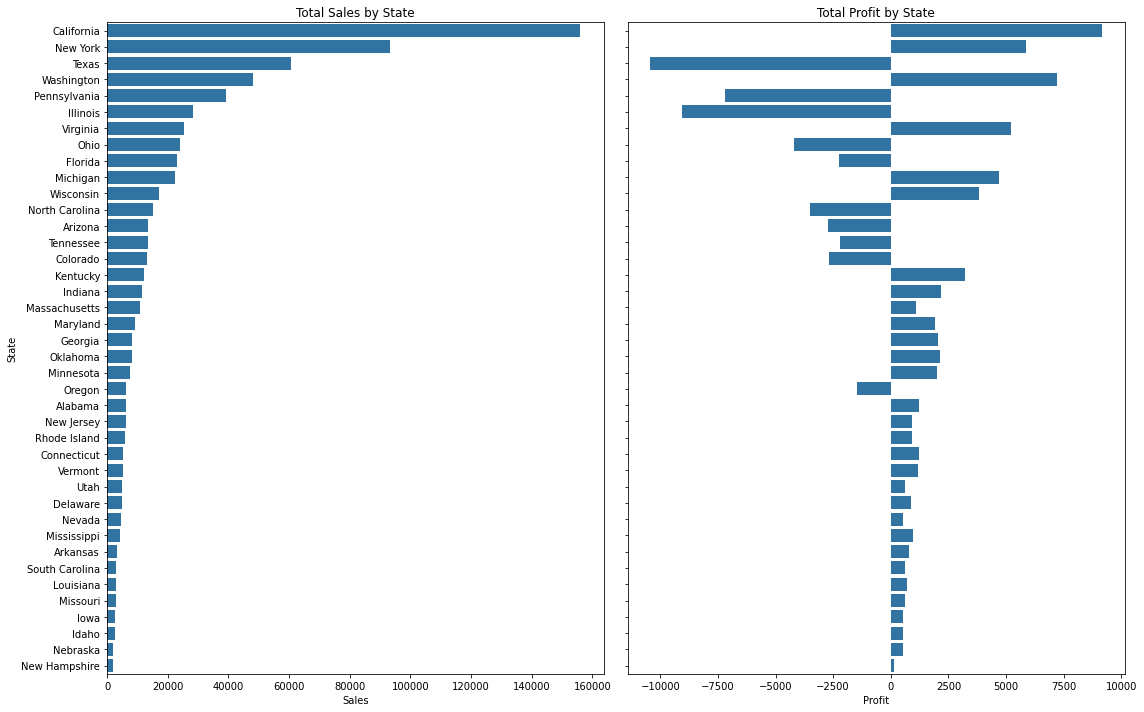

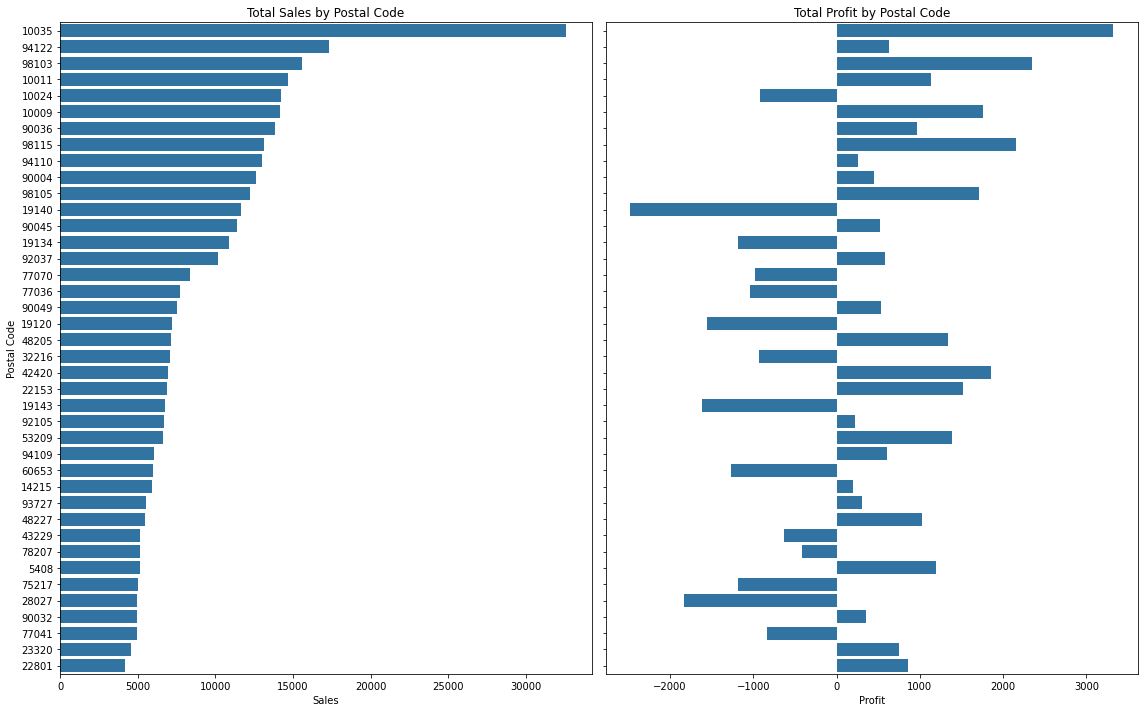

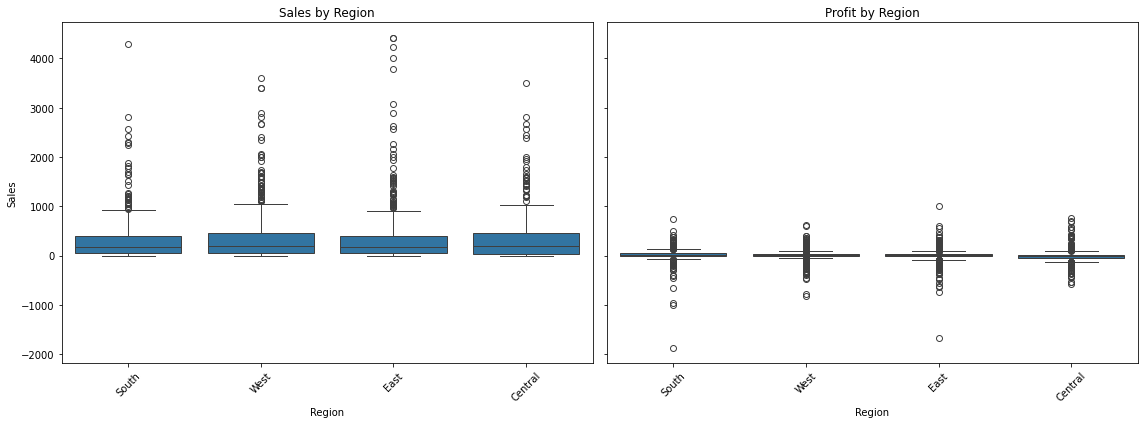

In [28]:
def plot_sales_profit_side_by_side(df, columns, limit = 40):
    """
    Plots Sales and Profit against given columns side-by-side.
    
    Parameters:
    df (pd.DataFrame): The dataset.
    columns (list): List of columns to plot against Sales and Profit.
    """
    for col in columns:
        # Check the number of unique categories in the column
        unique_categories = df[col].nunique()

        if unique_categories <= 10:  # Few categories -> Use boxplot
            fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
            
            sns.boxplot(x=col, y='Sales', data=df, ax=axes[0])
            axes[0].set_title(f"Sales by {col}")
            axes[0].tick_params(axis='x', rotation=45)

            sns.boxplot(x=col, y='Profit', data=df, ax=axes[1])
            axes[1].set_title(f"Profit by {col}")
            axes[1].tick_params(axis='x', rotation=45)

            plt.tight_layout()
            plt.show()

        else:  # Many categories -> Use bar plot (aggregated values)
            top_categories = df.groupby(col)['Sales'].sum().nlargest(limit).index

            filtered_df = df[df[col].isin(top_categories)]
            
            aggregated_df = filtered_df.groupby(col)[['Sales', 'Profit']].sum().sort_values(by='Sales', ascending=False).reset_index()

            fig, axes = plt.subplots(1, 2, figsize=(16, 10), sharey=True)
            
            sns.barplot(x='Sales', y=col, data=aggregated_df, ax=axes[0])
            axes[0].set_title(f"Total Sales by {col}")

            sns.barplot(x='Profit', y=col, data=aggregated_df, ax=axes[1])
            axes[1].set_title(f"Total Profit by {col}")

            plt.tight_layout()
            plt.show()

# Define the columns for analysis
columns_to_plot_category = ['Category', 'Sub-Category', 'Product Name']
columns_to_plot_segment = ['Segment', 'Customer Name']
columns_to_plot_ship_mode = ['Ship Mode']
columns_to_plot_geo = ['Country', 'City', 'State', 'Postal Code', 'Region']

# Call the function for each group
print("### Category and Sub-Category Analysis ###")
plot_sales_profit_side_by_side(df, columns_to_plot_category)

print("### Segment and Customer Name Analysis ###")
plot_sales_profit_side_by_side(df, columns_to_plot_segment)

print("### Ship Mode Analysis ###")
plot_sales_profit_side_by_side(df, columns_to_plot_ship_mode)

print("### Geography Analysis ###")
plot_sales_profit_side_by_side(df, columns_to_plot_geo)

**Shipping delay**

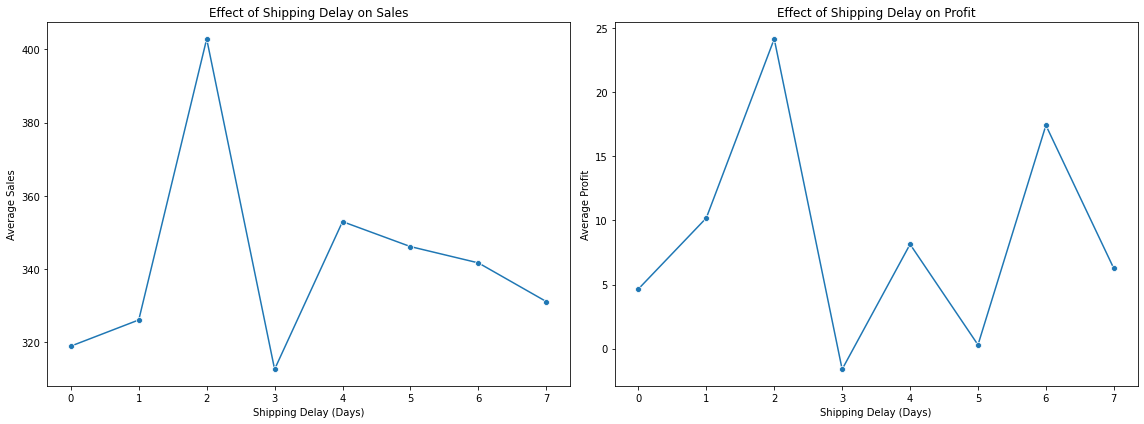

In [29]:
def visualize_shipping_delay_effect(df):
    """
    Visualizes the effect of shipping delay on Sales and Profit.
    
    Parameters:
    df (pd.DataFrame): The dataset with 'Order Date' and 'Ship Date'.
    """
    # Calculate shipping delay
    df['Shipping Delay (Days)'] = (df['Ship Date'] - df['Order Date']).dt.days

    # Group data by shipping delay
    delay_grouped = df.groupby('Shipping Delay (Days)')[['Sales', 'Profit']].mean().reset_index()

    # Plot the effect of shipping delay on Sales and Profit
    fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=False)
    
    sns.lineplot(x='Shipping Delay (Days)', y='Sales', data=delay_grouped, ax=axes[0], marker='o')
    axes[0].set_title("Effect of Shipping Delay on Sales")
    axes[0].set_xlabel("Shipping Delay (Days)")
    axes[0].set_ylabel("Average Sales")

    sns.lineplot(x='Shipping Delay (Days)', y='Profit', data=delay_grouped, ax=axes[1], marker='o')
    axes[1].set_title("Effect of Shipping Delay on Profit")
    axes[1].set_xlabel("Shipping Delay (Days)")
    axes[1].set_ylabel("Average Profit")
    
    plt.tight_layout()
    plt.show()
visualize_shipping_delay_effect(df)

Shouldn't this analysis be done regarding the type of products that is being delay? 

**Discount's effect**

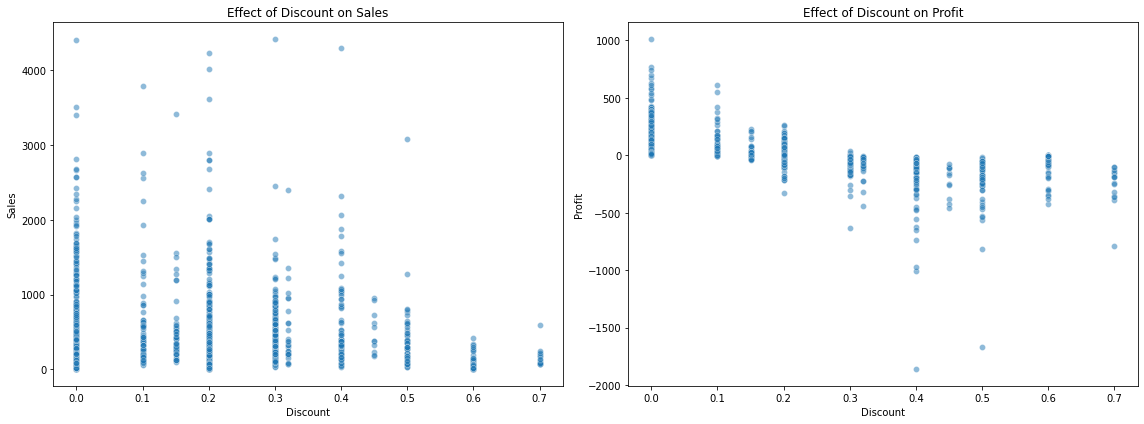

In [31]:
def visualize_discount_effect(df):
    """
    Visualizes the effect of Discount on Sales and Profit.
    
    Parameters:
    df (pd.DataFrame): The dataset with 'Discount', 'Sales', and 'Profit' columns.
    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    sns.scatterplot(x='Discount', y='Sales', data=df, ax=axes[0], alpha=0.5)
    axes[0].set_title("Effect of Discount on Sales")
    axes[0].set_xlabel("Discount")
    axes[0].set_ylabel("Sales")

    sns.scatterplot(x='Discount', y='Profit', data=df, ax=axes[1], alpha=0.5)
    axes[1].set_title("Effect of Discount on Profit")
    axes[1].set_xlabel("Discount")
    axes[1].set_ylabel("Profit")

    plt.tight_layout()
    plt.show()

visualize_discount_effect(df)

# Question #3 : Solution ML
Décris l'approche ML que tu as utilisé pour prévoir les ventes. Pourquoi as-tu choisi cette
approche? Quels sont les avantages et les inconvénients de cette approche? 

- Unsupervised for recommendation 
